## Import tools

We are importing all the necessary libraries. 

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constructing a model (algorithm)

DTC (Decision Tree Classfier) is built in such a way that contains two kinds of nodes:
1. decision nodes which contain:
    1. condition which is defined by feature_index, threshold value for the particular feature
    
        feature_index is the index of a feature
        threshold - certain value of a feature that we use to compare other feature values it. 

    2. left, right are for accessing left and right child.
    3. inforamtion gain - variable that stores the information gained by the split 

2. leaf nodes which contain: value which is a majority class of the leaf node. - it helps us to determine the class of a data point if it ends up in this particular leaf node. 

First we will define a Node class, then we are defining a Tree class which will have all the methods that we can perform on our tree. Tree class will basically allow us to build our tree based on the splits of our data that we will perform. Those splits and it's results (left and right child) will be in form of a Node that we have defined. 

## Node class

In [26]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None, curr_depth = 0):
        ''' constructor ''' 
        
        #for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain #this variable stores the information gained by the split denoted 
                                   #by this particulart decision node
        
        self.curr_depth = curr_depth #this variable is for current depth of a node. It's for both type of nodes.
        
        #for leaf node
        self.value = value
                            #majority class of the leaf node...
            
                            #it will help us to determine the class of a new data point 
                            #if the data point ends up in this particular leaf node
        

## Tree class

In [27]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
        #if in a particular node the number of samples becomes less than 
        #min_samples_split we won't split that node any further, we will
        #treat that node as a leaf node. Same goes for max_depth.

                    
    #MOST IMPORTANT FUNCTION - recursive function for building a binary tree using a recursive function. 
    #This function takes dataset as an input, performs a best split of the dataset - creating left and right child,
    #which either can be pure leaf node (node with only data points with one class) 
    #or a node with the remaining data and the condition that performs further splits of the data in that node.

    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        #splitting the dataset into two seperate variables, one containing feature and other containing the classes.
        X, Y = dataset[:,:-1], dataset[:,-1]
        
        #extracting the number of samples and the number of features 
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"], curr_depth=curr_depth)
        
        # compute leaf nod
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value, curr_depth=curr_depth)
    
    
    #SECOND MOST IMPORTANT FUNCTION
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            
            possible_thresholds = np.unique(feature_values)
            # loop over all the unique feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    
                    #extracing the classes of the dataset before split, as well as the classes of the
                    #right and left child after the split. (we use these array for computing information gain)
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    
                    #compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    
                    #update the best split (dictionary) if needed (we will update it if the current information gain 
                    #is greater than the previous one.)
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        #left side contains data points that meet our threshold condition, passing all the rows 
        #for which the feature value is less or equal to threshold.
        
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        #right side contains those rows for which the particular value is greater than threshold.

        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
            
            #here we can see two types of measuring the information contained in a system, gini and entropy.
            #entropy = ∑-p_i*log(p_i)
            #gini_index = 1 - ∑p_i**2, 
                #where p_i = probability of class i 
                #Why would we use gini function? Unlike entropy function, gini doesn't have logarithmic part,
                #so by choosing gini function we have actually done a favor to us which is saving computation time - 
                #(it is easier to find square of a quantity than to find the logarithm.)
            
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
    
    
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        #the value of a leaf node is the majority class present in the node
        #so...we just need to find the most occuring element in y!
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    
    
    #THIS FUNCTION HELPS US TO VISUALIZE DECISION TREE
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "≤", tree.threshold, "?", np.round(tree.info_gain,3))
            print(tree.curr_depth + 1,":","%sleft: " % (indent), end="")
            self.print_tree(tree.left, indent + "   ")
            print(tree.curr_depth + 1 ,":","%sright: " % (indent), end="")
            self.print_tree(tree.right, indent + "   ")
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

# Analysis of the first dataset
---

### About Dataset

**Context**

The Iris flower data set is a multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper "The use of multiple measurements in taxonomic problems". It is sometimes called Anderson's Iris data set because Edgar Anderson collected the data to quantify the morphologic variation of Iris flowers of three related species. The data set consists of 50 samples from each of three species of Iris (Iris Setosa, Iris Virginica, and Iris Versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.

This dataset became a typical test case for many statistical classification techniques in machine learning such as support vector machines

**Reference**

 R. A. Fisher (1936). "The use of multiple measurements in taxonomic problems". Annals of Eugenics. 7 (2): 179–188.
 
 https://en.wikipedia.org/wiki/Iris_flower_data_set

**Content**

The dataset contains a set of 150 records under 5 attributes - Petal Length, Petal Width, Sepal Length, Sepal width and Class(Species).

---
So, our objective here is to predict the class that is the specie of the iris flower, given it's features which are:
1. sepal_length
2. sepal width
3. petal_length
4. petal_width

The classes are species of flowering plant in the genus Iris of the family Iridaceae. Here we have three classes:
1. Setosa 
2. Versicolar
3. Virginica 


## Get the data

In [28]:
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data = pd.read_csv("iris_data.csv", names=col_names)
data

sepal_length  sepal_width  petal_length  petal_width            type
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]

<div>
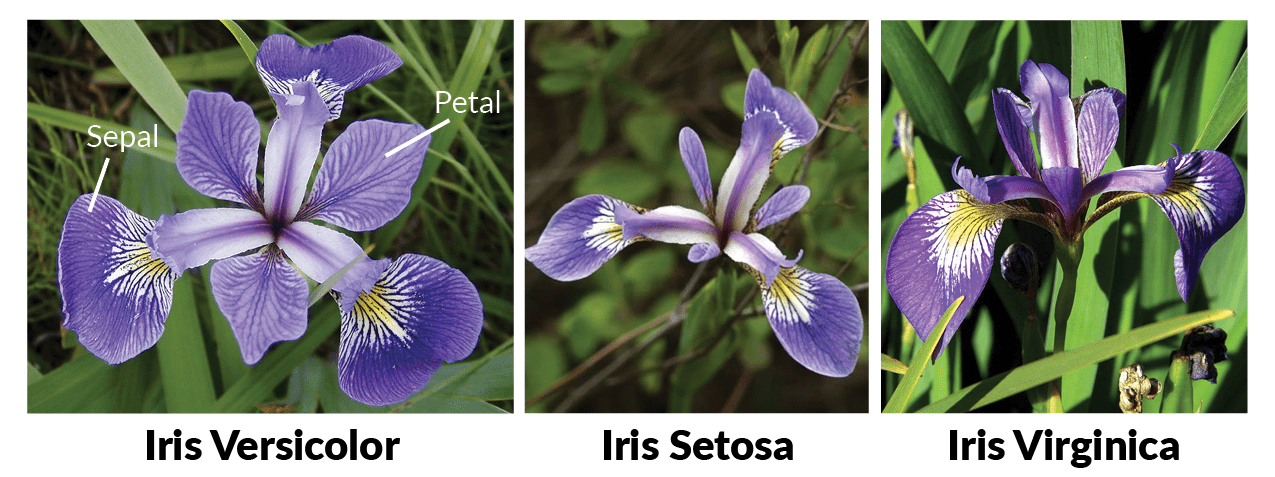 
</div>

---

Let's now implement our algorithm on this dataset. 

## Train-Test split
Here I am creating train and test dataset. We will train our model on Train dataset and test it with Test dataset.

In [29]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

## Fit the model

We first create the constructor of DecisionTreeClassfier class and then build a model by fitting constructor with the train dataset. 

In [30]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train)

## Model visualization

We will use the method print.tree() to visualize our tree.

In [31]:
classifier.print_tree()

X_2 ≤ 1.9 ? 0.337
1 :  left: Iris-setosa
1 :  right: X_3 ≤ 1.5 ? 0.427
2 :     left: X_2 ≤ 4.9 ? 0.051
3 :        left: Iris-versicolor
3 :        right: Iris-virginica
2 :     right: X_2 ≤ 5.0 ? 0.02
3 :        left: X_1 ≤ 2.8 ? 0.208
4 :           left: Iris-virginica
4 :           right: Iris-versicolor
3 :        right: Iris-virginica


## Testing the model

We are using definded method predict() to determine the classes of the Test dataset - those will be stored in the Y_pred which we will then compare to Y_test with the help of sklearn library function called accuracy_score

In [41]:
Y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.9333333333333333

# Analysis of the second dataset
---

Our objective here is to predict if the customer will purchase the iPhone or not given their gender, age and salary.

### About the data 

Despite all the effort I couldn't find the origin of this data therefore it shouldn't be used for any other purposes. 
The dataset contains a set of 400 records under 4 attributes - Gender, Age, Salary and Class( whether the person made a purchase or not).

## Get the data

In [33]:
dataset = pd.read_csv("iphone_purchase_records.csv")

In [34]:
dataset

Gender  Age  Salary  Purchase Iphone
0      Male   19   19000                0
1      Male   35   20000                0
2    Female   26   43000                0
3    Female   27   57000                0
4      Male   19   76000                0
..      ...  ...     ...              ...
395  Female   46   41000                1
396    Male   51   23000                1
397  Female   50   20000                1
398    Male   36   33000                0
399  Female   49   36000                1

[400 rows x 4 columns]

## Converting gender to number

In [35]:
#Convert gender variable into dummy/indicator variables or (binary vairbles) essentialy 1's and 0's.
#I chose the variable name one_hot_data bescause in ML one-hot is a group of bits among which the 
#legal combinations of values are only those with a single high (1) bit and all the others low (0)

one_hot_data = pd.get_dummies(dataset)
new_cols = ["Gender_Female", "Gender_Male", "Age", "Salary","Purchase Iphone"]
data2 = one_hot_data[new_cols]
data2

Gender_Female  Gender_Male  Age  Salary  Purchase Iphone
0                0            1   19   19000                0
1                0            1   35   20000                0
2                1            0   26   43000                0
3                1            0   27   57000                0
4                0            1   19   76000                0
..             ...          ...  ...     ...              ...
395              1            0   46   41000                1
396              0            1   51   23000                1
397              1            0   50   20000                1
398              0            1   36   33000                0
399              1            0   49   36000                1

[400 rows x 5 columns]

## Train-Test split

In [36]:
X2 = data2.iloc[:, :-1].values
Y2 = data2.iloc[:, -1].values.reshape(-1,1)

from sklearn.model_selection import train_test_split
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=.2, random_state=41)

In [37]:
len(X_train2), len(X_test2)

(320, 80)

## Fit the model 

In [38]:
classifier2 = DecisionTreeClassifier(min_samples_split=3, max_depth=10)
classifier2.fit(X_train2,Y_train2)

## Visualizing the model 

In [39]:
classifier2.print_tree()

X_2 ≤ 42 ? 0.176
1 :  left: X_3 ≤ 90000 ? 0.185
2 :     left: X_2 ≤ 36 ? 0.005
3 :        left: 0
3 :        right: X_3 ≤ 80000 ? 0.049
4 :           left: X_3 ≤ 74000 ? 0.018
5 :              left: X_2 ≤ 37 ? 0.003
6 :                 left: X_3 ≤ 62000 ? 0.03
7 :                    left: 0
7 :                    right: X_3 ≤ 70000 ? 0.375
8 :                       left: 1
8 :                       right: 0
6 :                 right: 0
5 :              right: X_2 ≤ 39 ? 0.022
6 :                 left: X_3 ≤ 79000 ? 0.111
7 :                    left: X_0 ≤ 0 ? 0.056
8 :                       left: X_3 ≤ 77000 ? 0.444
9 :                          left: 0
9 :                          right: 1
8 :                       right: X_3 ≤ 78000 ? 0.444
9 :                          left: 1
9 :                          right: 0
7 :                    right: 0
6 :                 right: X_2 ≤ 41 ? 0.052
7 :                    left: 0
7 :                    right: X_0 ≤ 0 ? 0.111
8 :                 

## Testing the model

In [40]:
Y_pred2 = classifier2.predict(X_test2)

from sklearn.metrics import accuracy_score
accuracy_score(Y_test2, Y_pred2)

0.8625